<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/klett_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

!git clone https://github.com/luancordeiro/lidarpy.git
os.chdir("lidarpy")

Cloning into 'lidarpy'...
remote: Enumerating objects: 1107, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1107 (delta 178), reused 159 (delta 85), pack-reused 852
Receiving objects: 100% (1107/1107), 67.40 MiB | 27.35 MiB/s, done.
Resolving deltas: 100% (794/794), done.
Checking out files: 100% (178/178), done.


# Importing the data

In [3]:
from lidarpy.data.read_binary import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]
files.sort()

data = GetData(directory, files)
lidar_data = data.get_xarray()
lidar_data.phy.shape

(119, 5, 16380)

# Removing the background noise and grouping the bins

In [6]:
lidar_data.coords["rangebin"][-1]

<xarray.DataArray 'rangebin' ()>
array(122850.)
Coordinates:
    rangebin  float64 1.228e+05

In [30]:
from lidarpy.data.manipulation import remove_background, groupby_nbins

nbins = 4

lidar_clean = (
    lidar_data
    .pipe(remove_background, [lidar_data.coords["rangebin"][-1] - 5000, 
                              lidar_data.coords["rangebin"][-1]])
    .pipe(groupby_nbins, nbins)
    .mean("time")
    .sel(channel="355_1"))

# Getting the atmospheric data

In [31]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

da_klett = lidar_clean.sel(rangebin=slice(min(df_sonde["alt"]), 
                                          max(df_sonde["alt"])))
z_klett = da_klett.coords["rangebin"]

temperature = f_temp(z_klett)
pressure = f_pres(z_klett)

# Klett inversion

In [32]:
from lidarpy.inversion.klett import Klett

klett = Klett(da_klett, 
              355,
              pressure,
              temperature,
              [9000, 11000],
              19
              )

In [33]:
alpha, beta, lr = klett.fit()

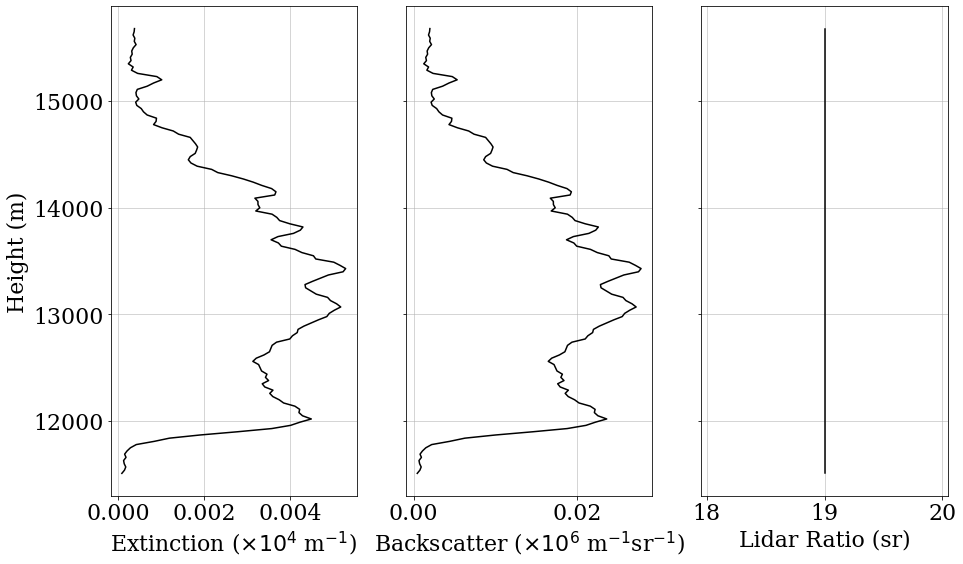

In [37]:
from lidarpy.plot.plotter import plot_3graph_std

ind = (z_klett >= 11500) & (z_klett <= 15_700)

plot_3graph_std(z_klett[ind], 
                alpha[ind], 
                beta[ind], 
                lr * np.ones(z_klett.shape)[ind])